In [1]:
import warnings
warnings.simplefilter("ignore")

import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

from scipy.stats import gmean, rankdata

### Функции

In [2]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "data"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def feature_concatenation(df:pd.DataFrame, features:list)-> pd.DataFrame:
    """
    Конкатенация колонок из указанного списка.
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    features:list
        Список с названиями колонок для конкатенации.

    Returns
    -------
    df: pandas.core.frame.DataFrame
        Расширенная матрица признаков с новой колонкой признаков.
    """
    new_name = f'{features[0]}'
    data = df[new_name].astype('str')
    for i in range(1, len(features)):
        new_name += f'_{features[i][0]}'
        df[features[i]] = df[features[i]].astype('str')
        data += df[features[i]]
    df[new_name] = data
    
    return df

def transform_client_profile(df: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    
    """
    Изменение существующих признаков профиля клиента (заполнение пропусков, удаление выбросов) и создание новых признаков.

    Parameters
    ----------
    df: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    df: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.
    """
    
    if copy:
        df = df.copy()
    
    # Очистка данных
    df["days_on_last_job"] = df["days_on_last_job"].replace(365243, np.nan)
    df.loc[df['childrens']>7, 'childrens'] = 1
    df.loc[df['total_salary']>3000000, 'total_salary'] = df['total_salary'].median()
    df.loc[df['total_salary'].isnull(), 'total_salary'] = df['total_salary'].median()
    df.loc[df['amount_credit']>3000000, 'amount_credit'] = df['amount_credit'].median()
    df.loc[df['amount_credit']>3000000, 'amount_credit'] = df['amount_credit'].median()
    df.loc[df['amount_annuity']>200000, 'amount_annuity'] = df['amount_annuity'].median()
    df["own_car_age"] = df["own_car_age"].replace(np.nan, 0)
    df.loc[df['own_car_age']>60, 'own_car_age'] = df['own_car_age'].median()
   
    df['education_level'] = df['education_level'].replace('Secondary / secondary special', 'Secondary')
    df['education_level'] = df['education_level'].replace('Incomplete higher', 'I_higher')
    df['education_level'] = df['education_level'].replace('Lower secondary', 'L_secondary')
    df['education_level'] = df['education_level'].replace('Higher education', 'Higher')
    df['education_level'] = df['education_level'].replace('Academic degree', 'Academic')    
    
    # обработка external_scoring_rating
    df["external_scoring_rating_prod"] = df["external_scoring_rating_1"] * df["external_scoring_rating_2"] * df["external_scoring_rating_3"]
    df["external_scoring_rating_weighted"] = df.external_scoring_rating_1 * 2 + df.external_scoring_rating_2 + df.external_scoring_rating_3 * 3
    df["external_scoring_rating_weighted_2"] = df.external_scoring_rating_1/(df.external_scoring_rating_2 + df.external_scoring_rating_3)
    df["external_scoring_rating_prod_log"] = np.log(df["external_scoring_rating_prod"])
        
    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        df[feature_name] = eval("np.{}".format(function_name))(
            df[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )
          
    # конкатенация категориальных признаков
    df = feature_concatenation(df, ['gender', 'education_level', 'family_status'])
    df = feature_concatenation(df, ['education_level', 'family_status'])
    
    # bki 
    bki_flags = [flag for flag in df.columns if "amt_req_credit_bureau" in flag]
    df["bki_requests_count"] = df[bki_flags].sum(axis=1)
    df["bki_kurtosis"] = df[bki_flags].kurtosis(axis=1)    

    # Отношение между основными фин. показателями
    df['ratio_credit_to_annuity'] = df['amount_credit'] / df['amount_annuity']
    df["ratio_annuity_to_salary"] = df['amount_annuity'] / df['total_salary']
    df['ratio_credit_to_salary'] = df['amount_credit'] / df['total_salary']
    df["ratio_salary_to_family_size"] = df["total_salary"] / df["family_size"]
    #df["total_salary_net"] = df["total_salary"] - df["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    df["ratio_annuity_to_age"] = df["amount_annuity"] / df["age"]
    df["ratio_credit_to_age"] = df["amount_credit"] / df["age"]
    df["ratio_salary_to_age"] = df["total_salary"] / df["age"]
    df["ratio_salary_to_experience"] = df["total_salary"] / df["days_on_last_job"]
    df["ratio_credit_to_experience"] = df["amount_credit"] / df["days_on_last_job"]
    df["ratio_annuity_to_experience"] = df["amount_annuity"] / df["days_on_last_job"]

    # Отношение врменных признаков
    df["ratio_age_to_experience"] = df["age"] / df["days_on_last_job"]
    df["ratio_salary_to_region_population"] = df["total_salary"] * df["region_population"]
    df["ratio_car_to_experience"] = df["own_car_age"] / df["days_on_last_job"]
    df["ratio_car_to_age"] = df["own_car_age"] / df["age"]
    df["ratio_age_experience_salary"] = df["age"] * df["days_on_last_job"] / df["total_salary"]
    df["ratio_year_to_age"] = df["amount_annuity"] / df["age"]

    # Произведение фин. показателей кредита на вероятность дефолта - ожидаемые потери
    df["expected_total_loss_1"] = df["external_scoring_rating_1"] * df["amount_credit"]
    df["expected_total_loss_2"] = df["external_scoring_rating_2"] * df["amount_credit"]
    df["expected_total_loss_3"] = df["external_scoring_rating_3"] * df["amount_credit"]
    df["expected_monthly_loss_1"] = df["external_scoring_rating_1"] * df["amount_annuity"]
    df["expected_monthly_loss_2"] = df["external_scoring_rating_2"] * df["amount_annuity"]
    df["expected_monthly_loss_3"] = df["external_scoring_rating_3"] * df["amount_annuity"]
    df["expected_monthly_loss_weighted"] = df["external_scoring_rating_weighted"] * df["amount_annuity"] 
    df["expected_monthly_loss_weighted2"] = df["external_scoring_rating_weighted_2"] * df["amount_annuity"]
    
    
    df = df.replace(np.inf, np.nan)
    df = df.replace(-np.inf, np.nan)
    
    return df
    

def encode_labels(df):
    """
    Label encoder для категориальных признаков
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    Returns
    -------
    df: pandas.core.frame.DataFrame
        Датафрейм с измененными категориальными признаками.
    """
    categorical_cols = df.select_dtypes(include="object")
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].fillna('null'))
        
    return df



In [3]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=100,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)

    return estimators, oof_preds


def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """

            
    estimators, folds_scores = [], []
    
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", 
            verbose=500, 
            early_stopping_rounds=500
        )
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)
    return estimators, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
#     X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)
    return estimators, oof_preds

#### Загрузка и подготовка данных

In [4]:
train = get_input("train.csv")
test = get_input("test.csv")

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


In [5]:
train_index = train['application_number']
test_index = test['application_number']

In [6]:
client_profile = get_input("client_profile.csv")
client_profile = transform_client_profile(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,...,ratio_age_experience_salary,ratio_year_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,expected_monthly_loss_weighted,expected_monthly_loss_weighted2
0,123666076,F,0,157500.0,270000.0,13500.0,I_higher,Civil marriage,0.008068,8560,...,84.186921,1.577103,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,39567.952153,4861.669998
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary,Married,0.020246,23187,...,NaN,1.227714,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,NaN,NaN


In [7]:
train = train.merge(client_profile, on='application_number', how='left')
test = test.merge(client_profile, on='application_number', how='left')

In [8]:
target = train['target']

In [9]:
train = train.drop(['application_number', 'target'], axis=1)
test = test.drop(['application_number'], axis=1)

In [10]:
train = encode_labels(train)
test = encode_labels(test)

#### Модели

In [11]:
xgb_params = {
#     "booster": "dart",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 100000,
#     "reg_lambda": 0.2,
    "max_depth": 3,
#     "gamma": 0.2,
#     "nthread": 2,
    "seed": 99,
    'grow_policy': 'lossguide',
    'max_leaves' : 1000,
#     'sample_type':'weighted',
#     'normalize_type': 'forest'
}
    
cv_strategy = KFold(n_splits=7, random_state=49, shuffle=True)

In [12]:
estimators_xgb, oof_score_xgb = xgboost_cross_validation(
    xgb_params, train, target,  cv=cv_strategy
)

Mon Dec 21 22:34:50 2020, Cross-Validation, 110093 rows, 61 cols
[22:34:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.68885	valid-auc:0.68574
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.70176	valid-auc:0.70018
[200]	train-auc:0.70521	valid-auc:0.70368
[300]	train-auc:0.71111	valid-auc:0.70959
[400]	train-auc:0.71944	valid-auc:0.71642
[500]	train-auc:0.72505	valid-auc:0.72042
[600]	train-auc:0.72959	valid-auc:0.72321
[700]	train-auc:0.73315	valid-auc:0.72499
[800]	train-auc:0.73608	valid-auc:0.72683
[900]	train-auc:0.73787	v

Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.70408	valid-auc:0.69239
[200]	train-auc:0.70796	valid-auc:0.69424
[300]	train-auc:0.71242	valid-auc:0.69853
[400]	train-auc:0.72049	valid-auc:0.70504
[500]	train-auc:0.72687	valid-auc:0.70941
[600]	train-auc:0.73122	valid-auc:0.71273
[700]	train-auc:0.73457	valid-auc:0.71506
[800]	train-auc:0.73724	valid-auc:0.71683
[900]	train-auc:0.73931	valid-auc:0.71911
[1000]	train-auc:0.74185	valid-auc:0.71867
Stopping. Best iteration:
[900]	train-auc:0.73931	valid-auc:0.71911

Fold 7, Valid score = 0.71867
Score by each fold: [0.72992, 0.72006, 0.72709, 0.73641, 0.72997, 0.72183, 0.71867]
Mean score by each fold:0.7262785714285714


In [13]:
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.01,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'colsample_bytree': 0.5,
    'min_split_gain': 0.01,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
       
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, train, target, cv=cv_strategy, 
)

Mon Dec 21 22:43:04 2020, Cross-Validation, 110093 rows, 61 cols
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.733217
[1000]	valid_0's auc: 0.734389
Early stopping, best iteration is:
[882]	valid_0's auc: 0.734629
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.718783
[1000]	valid_0's auc: 0.721075
[1500]	valid_0's auc: 0.718768
Early stopping, best iteration is:
[1043]	valid_0's auc: 0.721334
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.731521
[1000]	valid_0's auc: 0.731208
Early stopping, best iteration is:
[622]	valid_0's auc: 0.732713
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.735509
[1000]	valid_0's auc: 0.735992
Early stopping, best iteration is:
[842]	valid_0's auc: 0.737007
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.732132
[1000]	valid_0's auc: 0.731908
Early stopping, best iterati

In [14]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 120,
    "verbose": 100,
    "learning_rate": 0.01,
    "max_depth": 8,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 100,
    "thread_count": 5,
    "random_seed": 42,
}
estimators_cb, oof_preds_cb = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv_strategy
)

Mon Dec 21 22:44:21 2020, Cross-Validation, 110093 rows, 61 cols
0:	test: 0.6624470	test1: 0.6487714	best: 0.6487714 (0)	total: 104ms	remaining: 17m 19s
100:	test: 0.7178968	test1: 0.7142551	best: 0.7142551 (100)	total: 4.09s	remaining: 6m 40s
200:	test: 0.7243971	test1: 0.7190287	best: 0.7190287 (200)	total: 8.23s	remaining: 6m 41s
300:	test: 0.7329476	test1: 0.7231449	best: 0.7231449 (300)	total: 12.5s	remaining: 6m 43s
400:	test: 0.7402320	test1: 0.7259050	best: 0.7260072 (397)	total: 16.9s	remaining: 6m 43s
500:	test: 0.7459050	test1: 0.7276949	best: 0.7280990 (490)	total: 21.1s	remaining: 6m 40s
600:	test: 0.7513669	test1: 0.7285556	best: 0.7287386 (570)	total: 25.3s	remaining: 6m 35s
700:	test: 0.7564272	test1: 0.7289847	best: 0.7293248 (619)	total: 29.4s	remaining: 6m 30s
800:	test: 0.7610754	test1: 0.7292077	best: 0.7295958 (752)	total: 33.6s	remaining: 6m 25s
900:	test: 0.7658004	test1: 0.7303687	best: 0.7304227 (896)	total: 37.7s	remaining: 6m 20s
1000:	test: 0.7701617	test1:

#### Смотрим корреляцию OOF-predictions

In [15]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb": oof_score_xgb,
    "cb": oof_preds_cb 
})

corr = scores.corr()

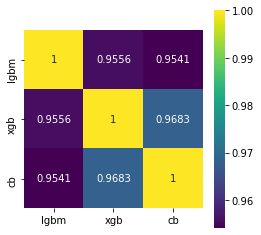

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

##### AMean

In [17]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7286


##### GMean

In [18]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7286


#### Предсказания 3 моделей

In [21]:
prediction_xgb = np.zeros(test.shape[0])
for model in estimators_xgb:
    prediction_xgb+=model.predict(xgb.DMatrix(test))
prediction_xgb = prediction_xgb/len(estimators_xgb)

In [22]:
prediction_lxbm = np.zeros(test.shape[0])
for model in estimators_lgbm:
    prediction_lxbm+=model.predict_proba(test)[:, 1]
            
prediction_lxbm = prediction_lxbm/len(estimators_lgbm)

In [23]:
prediction_cb = np.zeros(test.shape[0])
for model in estimators_cb:
    prediction_cb+=model.predict_proba(test)[:, 1]
            
prediction_cb = prediction_cb/len(estimators_cb)

In [24]:
preds = pd.DataFrame({
    "lgbm": prediction_lxbm,
    "xgb": prediction_xgb,
    "cb": prediction_cb 
})

corr = preds.corr()

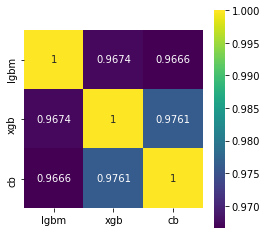

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

#### Отбор признаков и построение нового сета с 10 важными признаками и OOF-scores

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train, target, train_size=0.75, shuffle=True, random_state=25,
)

In [27]:
train_pool = cb.Pool(x_train, y_train)
valid_pool = cb.Pool(x_valid, y_valid)

In [28]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
fit_model = model.fit(train_pool, eval_set=[(train_pool), (valid_pool)])

0:	test: 0.6280529	test1: 0.6344761	best: 0.6344761 (0)	total: 26.6ms	remaining: 53.1s
100:	test: 0.7112321	test1: 0.7105043	best: 0.7105043 (100)	total: 2.53s	remaining: 47.6s
200:	test: 0.7161418	test1: 0.7125418	best: 0.7127311 (187)	total: 5.06s	remaining: 45.3s
300:	test: 0.7222868	test1: 0.7172851	best: 0.7173480 (297)	total: 7.64s	remaining: 43.1s
400:	test: 0.7273714	test1: 0.7194774	best: 0.7194919 (395)	total: 10.2s	remaining: 40.8s
500:	test: 0.7315376	test1: 0.7217677	best: 0.7217677 (500)	total: 12.8s	remaining: 38.2s
600:	test: 0.7349344	test1: 0.7229102	best: 0.7229636 (594)	total: 15.3s	remaining: 35.6s
700:	test: 0.7381172	test1: 0.7233737	best: 0.7233737 (700)	total: 17.8s	remaining: 33.1s
800:	test: 0.7408798	test1: 0.7242240	best: 0.7242240 (800)	total: 20.3s	remaining: 30.4s
900:	test: 0.7434737	test1: 0.7249013	best: 0.7249013 (900)	total: 22.9s	remaining: 27.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.725107893
bestIteration = 931

Shri

In [29]:
importance = permutation_importance(
    model, x_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [30]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [31]:
pd.set_option("display.max_columns", 30)

In [32]:
increase_scores = importance_scores[importance_scores["importance-mean"]>0.001428]

In [33]:
increase_scores = increase_scores['features'].tolist()

In [34]:
new_set = train[increase_scores].copy()
new_set_test = test[increase_scores].copy()

In [37]:
new_set['xgb'] = scores['xgb']
new_set_test['xgb'] = preds['xgb']
new_set['lgbm'] = scores['lgbm']
new_set_test['lgbm'] = preds['lgbm']
new_set['cb'] = scores['cb']
new_set_test['cb'] = preds['cb']

#### Обучение 3 моделей и предсказание целевой переменной

In [39]:
estimators_xgb, oof_score_xgb = xgboost_cross_validation(
    xgb_params, new_set, target,  cv=cv_strategy
)

Mon Dec 21 22:50:13 2020, Cross-Validation, 110093 rows, 14 cols
[22:50:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.72302	valid-auc:0.72350
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.73063	valid-auc:0.73337
[200]	train-auc:0.73131	valid-auc:0.73407
[300]	train-auc:0.73225	valid-auc:0.73369
[400]	train-auc:0.73316	valid-auc:0.73435
Stopping. Best iteration:
[338]	train-auc:0.73246	valid-auc:0.73458

Fold 1, Valid score = 0.7342
[22:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc

In [40]:
estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, new_set, target, cv=cv_strategy, 
)

Mon Dec 21 22:51:05 2020, Cross-Validation, 110093 rows, 14 cols
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.732788
Early stopping, best iteration is:
[8]	valid_0's auc: 0.733999
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.720326
Early stopping, best iteration is:
[13]	valid_0's auc: 0.722679
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.727917
Early stopping, best iteration is:
[14]	valid_0's auc: 0.7302
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.735847
[1000]	valid_0's auc: 0.734335
Early stopping, best iteration is:
[707]	valid_0's auc: 0.736119
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.730879
Early stopping, best iteration is:
[13]	valid_0's auc: 0.733747
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.726031
Early stopping, best iteration is:

In [41]:
estimators_cb, oof_preds_cb = catboost_cross_validation(
    params=cb_params, X=new_set, y=target, cv=cv_strategy
)

Mon Dec 21 22:51:26 2020, Cross-Validation, 110093 rows, 14 cols
0:	test: 0.6827425	test1: 0.6848771	best: 0.6848771 (0)	total: 21.1ms	remaining: 42.2s
100:	test: 0.7266922	test1: 0.7319301	best: 0.7324832 (62)	total: 2.26s	remaining: 42.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7324831728
bestIteration = 62

Shrink model to first 63 iterations.
Fold 1, Valid score = 0.73248
0:	test: 0.6839514	test1: 0.6772827	best: 0.6772827 (0)	total: 20.1ms	remaining: 40.2s
100:	test: 0.7288249	test1: 0.7185460	best: 0.7198988 (71)	total: 2.21s	remaining: 41.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7198987975
bestIteration = 71

Shrink model to first 72 iterations.
Fold 2, Valid score = 0.7199
0:	test: 0.6828336	test1: 0.6827060	best: 0.6827060 (0)	total: 20.5ms	remaining: 41.1s
100:	test: 0.7278470	test1: 0.7285533	best: 0.7289237 (87)	total: 2.35s	remaining: 44.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.72892368

In [42]:
prediction_xgb1 = estimators_xgb[3].predict(xgb.DMatrix(new_set_test))

prediction_lxbm1 = estimators_lgbm[3].predict_proba(new_set_test)[:, 1]

prediction_cb1 = estimators_cb[3].predict_proba(new_set_test)[:, 1]

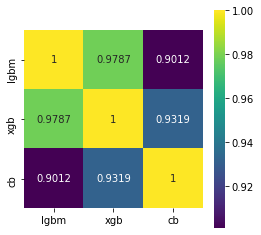

In [43]:
preds = pd.DataFrame({
    "lgbm": prediction_lxbm1,
    "xgb": prediction_xgb1,
    "cb": prediction_cb1 
})

corr = preds.corr()

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [44]:
preds = 0.6*prediction_lxbm1 + 0.4*prediction_xgb1

In [45]:
y_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_index,
    "TARGET": preds /2
})
y_pred.to_csv("one_from_model342.csv", index=False)